In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [2]:
# limit GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

def reset_session():
    K.get_session().close()
    K.set_session(K.tf.Session(config=config))

In [3]:
# define paths to image directories
train_path = 'sampled_photos/train'
valid_path = 'sampled_photos/val'

# create image data generators to feed the model from image directories
target_size = (224, 224)
batch_size = 8
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=target_size, 
                                                         batch_size=batch_size)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                         target_size=target_size,
                                                         batch_size=batch_size)

Found 9000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [4]:
def build_VGG16(width, new_weights=False, trainable=False):
    '''
    Builds a modified version of the VGG16 model for transfer learning
    
    Parameters:
    width(int) - number of nodes present in each of the two new FC layers after
        the convolutional layers
    new_weights(bool) - whether to reinitialize the weights in the VGG16
        convolutional layers
    trainable(bool) - whether to allow updating of convolutional weights
    
    Returns:
    Compiled keras functional API model object
    '''
    
    if new_weights == True:
        weights = None
    else:
        weights = 'imagenet'
    
    # import only the convolutional layers of VGG16
    base_model = VGG16(include_top=False, 
                       weights=weights, 
                       input_shape=(224, 224, 3))
    
    if trainable == False:
        for layer in base_model.layers:
            layer.trainable = False
    
    # add two FC layers to end of convolutional layers
    inputs = base_model.output
    x = Flatten()(inputs)
    x = Dense(width, activation='relu')(x)
    x = Dense(width, activation='relu')(x)
    preds = Dense(5, activation='softmax')(x)

    # compile model
    model = Model(inputs=base_model.inputs, outputs=preds)
    model.compile(optimizer=Adam(lr=0.0001, decay=0.1), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [5]:
def run_in_duplicate(width, n_epochs=10, new_weights=False, trainable=False):
    '''
    Runs two initialization and training passes for each model variation
    
    Returns the training history
    '''
    from datetime import datetime
    
    # define file name
    if new_weights == False and trainable == False:
        filename = 'vgg16_pretrained_{}_'.format(width)
    elif new_weights == False and trainable == True:
        filename = 'vgg16_trainable_{}_'.format(width)
    else:
        filename = 'vgg16_untrained_{}_'.format(width)
    
    datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('{} - Starting training for {}'.format(datetime_now, filename + '1'))
    
    # define callbacks for model fitting
    checkpointer = ModelCheckpoint(filename + '1.h5', 
                                   monitor='val_loss', 
                                   verbose=0, 
                                   save_best_only=True)
    
    # build first model
    model_1 = build_VGG16(width, new_weights=new_weights, trainable=trainable)
    
    # fit the model to the training data
    history_1 = model_1.fit_generator(train_batches, 
                                      steps_per_epoch=9000/batch_size, 
                                      validation_data=valid_batches, 
                                      validation_steps=1000/batch_size, 
                                      epochs=n_epochs, 
                                      callbacks=[checkpointer], 
                                      verbose=0)
    
    datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('{} - Starting training for {}'.format(datetime_now, filename + '2'))
    
    checkpointer = ModelCheckpoint(filename + '2.h5', 
                                   monitor='val_loss', 
                                   verbose=0, 
                                   save_best_only=True)
    
    # build second model
    model_2 = build_VGG16(width, new_weights=new_weights, trainable=trainable)
    
    # fit the model to the training data
    history_2 = model_2.fit_generator(train_batches, 
                                      steps_per_epoch=9000/batch_size, 
                                      validation_data=valid_batches, 
                                      validation_steps=1000/batch_size, 
                                      epochs=n_epochs, 
                                      callbacks=[checkpointer], 
                                      verbose=0)
    
    def avg_metric(metric):
        metric_1 = np.array(history_1.history[metric])
        metric_2 = np.array(history_2.history[metric])
        return (metric_1 + metric_2)/2
    
    # determine average metrics of the two runs
    acc = avg_metric('acc')
    loss = avg_metric('loss')
    val_acc = avg_metric('val_acc')
    val_loss = avg_metric('val_loss')
    
    # plot loss history
    plot_df = tuple([loss, val_loss])
    plot_df = np.column_stack(plot_df)
    plot_df = pd.DataFrame(plot_df, columns=('training', 'validation'))
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_df.plot(ax=ax)
    plt.title('Loss over epochs: {}'.format(filename))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, len(loss)))
    plt.legend(loc='upper right')
    plt.show()
    
    return {'acc': acc, 'loss':loss, 'val_acc':val_acc, 'val_loss':val_loss}

2018-08-26 22:22:30 - Starting training for vgg16_trainable_200_1
2018-08-26 23:38:38 - Starting training for vgg16_trainable_200_2


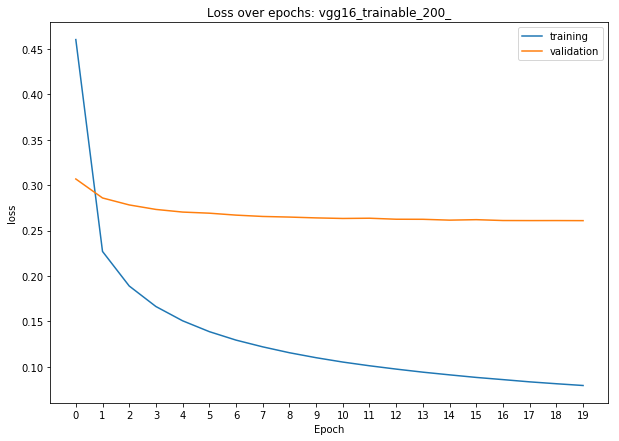

2018-08-27 00:55:40 - Starting training for vgg16_trainable_400_1
2018-08-27 02:15:03 - Starting training for vgg16_trainable_400_2


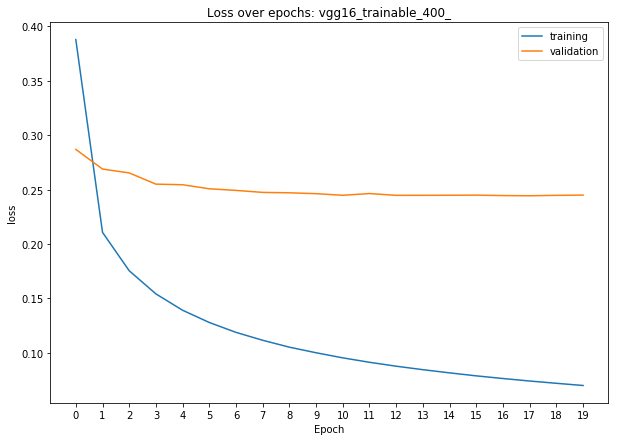

2018-08-27 03:33:00 - Starting training for vgg16_trainable_600_1
2018-08-27 04:53:48 - Starting training for vgg16_trainable_600_2


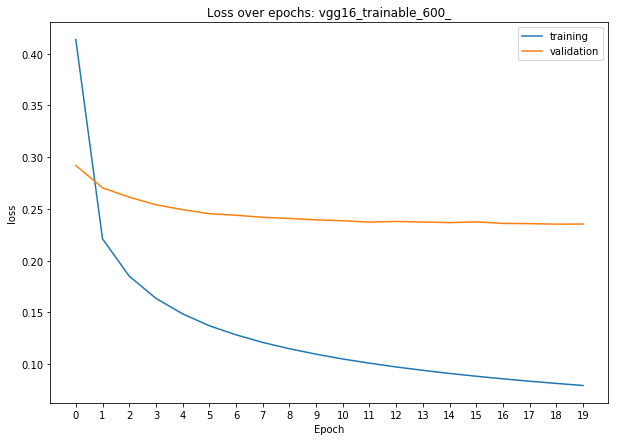

2018-08-27 06:13:49 - Starting training for vgg16_trainable_800_1
2018-08-27 07:36:07 - Starting training for vgg16_trainable_800_2


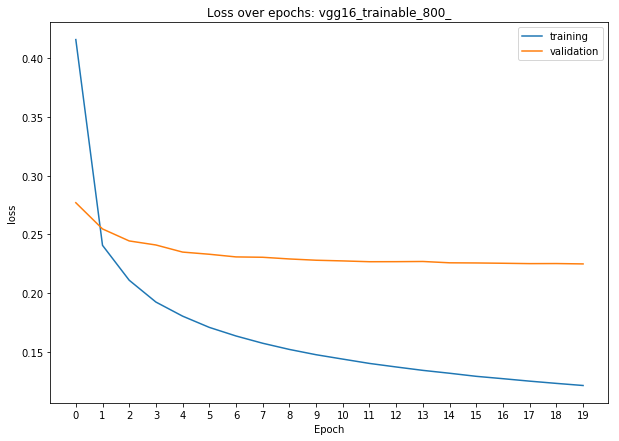

2018-08-27 08:58:16 - Starting training for vgg16_trainable_1000_1
2018-08-27 10:22:16 - Starting training for vgg16_trainable_1000_2


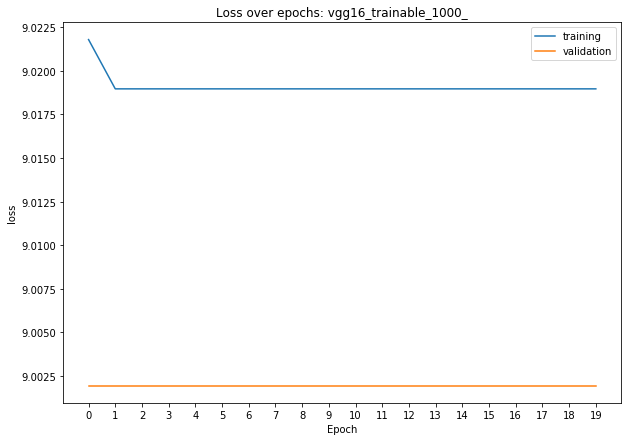

In [6]:
# test different widths for model
widths = [200, 400, 600, 800, 1000]

histories = dict()

for width in widths:
    histories[width] = run_in_duplicate(width, n_epochs=20, new_weights=False, trainable=True)

reset_session()

In [7]:
K.get_session().close()

In [8]:
# save history as json
pd.DataFrame(histories).transpose().to_json('VGG16_width_comparison_history.json')

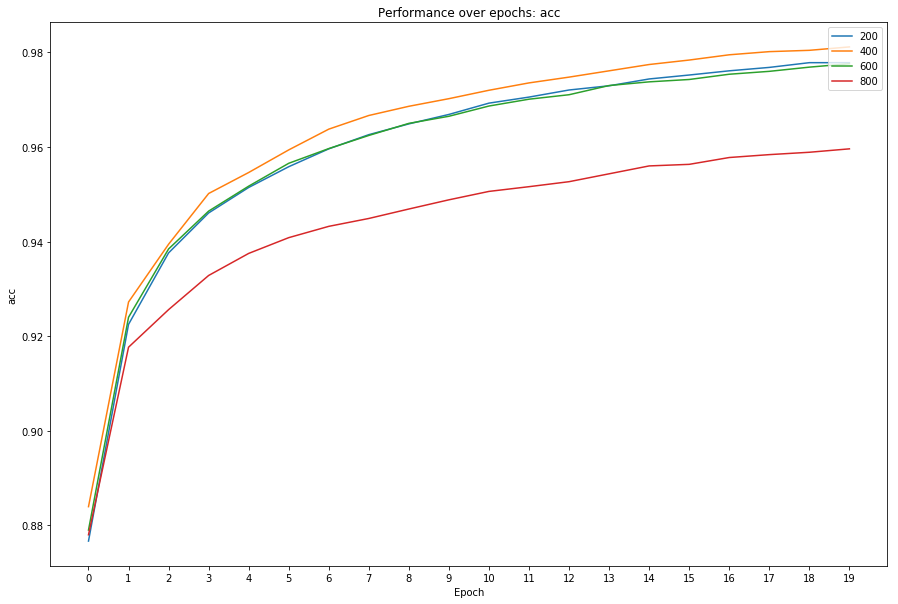

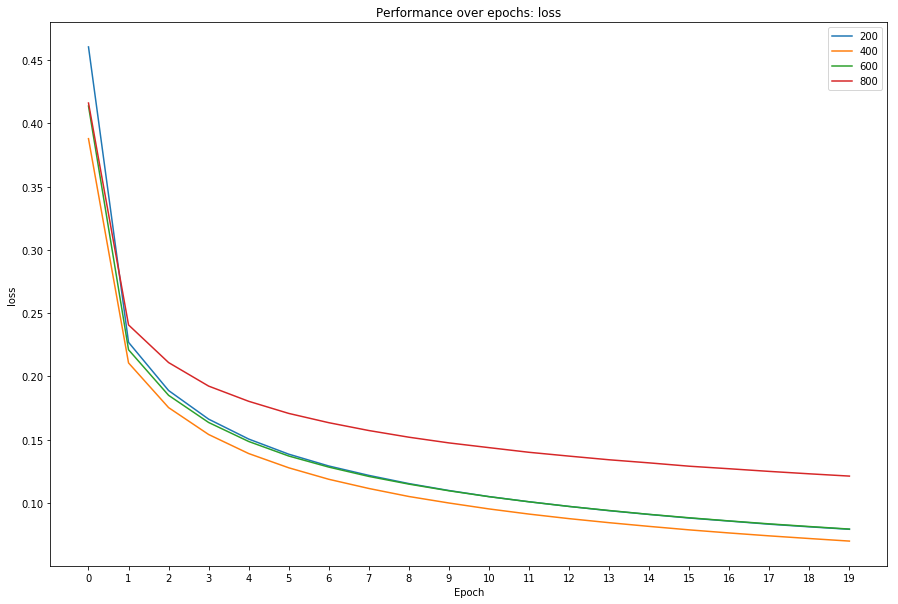

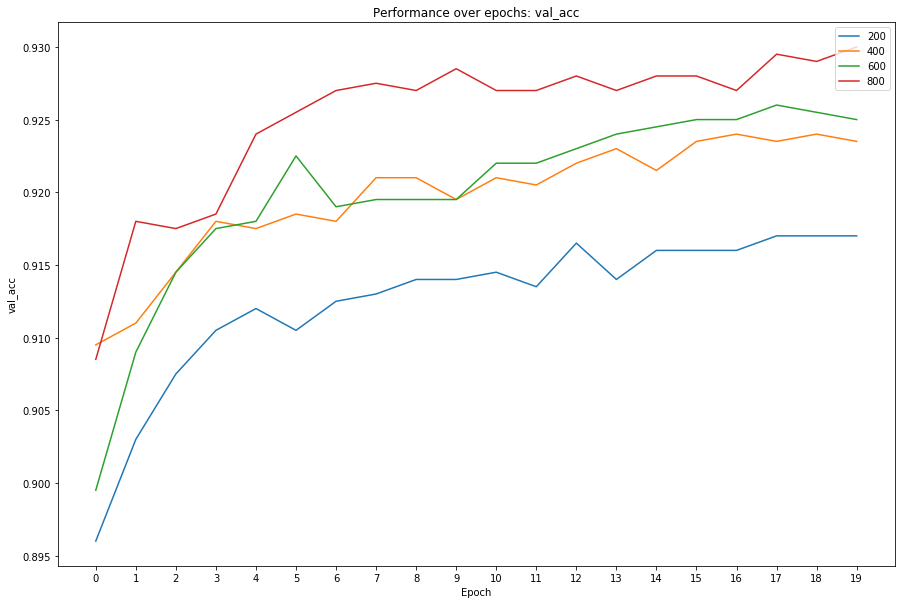

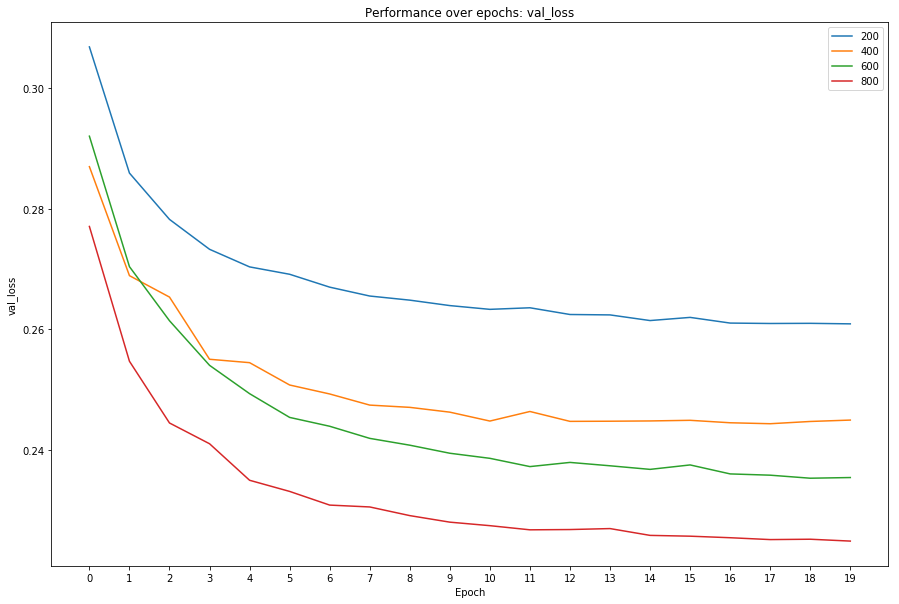

In [14]:
def plot_metric(metric, histories):
    # extract metric of interest
    hist_df = pd.DataFrame()
    for i, history in histories.iterrows():
        hist_df[i] = history[metric]

    # plot history
    fig, ax = plt.subplots(figsize=(15, 10))
    hist_df.plot(ax=ax)
    plt.title('Performance over epochs: {}'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.xticks(range(0, len(hist_df.iloc[:, 1])))
    plt.legend(loc='upper right')
    plt.show()

# load history from json
histories = pd.read_json('VGG16_width_comparison_history.json')

# remove 1000-width model from graph, since it failed to converge
histories.drop(1000, axis='index', inplace=True)
    
plot_metric('acc', histories)
plot_metric('loss', histories)
plot_metric('val_acc', histories)
plot_metric('val_loss', histories)